### Initial Modeling Approach (Approach A)

In this section, we performed **scaling, encoding, and transformations** on the original dataset to create multiple preprocessed versions. Each version applied different combinations of preprocessing techniques to better prepare the data for modeling.

We then applied **various classifiers using default hyperparameters** to each version of the dataset. This allowed us to observe how different models reacted to different types of input preprocessing.

To evaluate the performance of each model-version combination, we used **cross-validation**. This helped us compare results more fairly and identify the **best-performing models and preprocessing pipelines**. These findings guided the selection of the top models we would later fine-tune in Approach B.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA


In [3]:
# Load dataset
df = pd.read_csv('alzheimers_prediction_dataset.csv')

df = df.drop(['Gender', 'Education Level', 'BMI', 'Physical Activity Level', 'Smoking Status',
              'Alcohol Consumption', 'Diabetes', 'Hypertension', 'Cholesterol Level', 'Cognitive Test Score',
              'Depression Level', 'Sleep Quality', 'Dietary Habits', 'Air Pollution Exposure',
              'Employment Status', 'Marital Status', 'Social Engagement Level', 'Income Level',
              'Stress Levels', 'Urban vs Rural Living'], axis=1)


In [4]:
# Separate features and target
X = df.drop(columns=["Alzheimer’s Diagnosis"])
y = df["Alzheimer’s Diagnosis"].map({'No': 0, 'Yes': 1})  # convert target to 0/1


In [5]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Dataset V1 – Preprocessing Summary

This version of the dataset applies the following preprocessing steps:

1. **Scaling of numeric features** using `RobustScaler` to reduce the influence of outliers.
2. **Encoding of categorical features** using `OrdinalEncoder`, assigning integer values to each category.

This version will be used to evaluate baseline model performance under these preprocessing conditions.


In [7]:
# Copy original data
X_train_V1 = X_train.copy()
X_test_V1 = X_test.copy()

# Step 1: Scale numeric features using RobustScaler
numeric_features = ['Age']
scaler = RobustScaler()
X_train_V1[numeric_features] = scaler.fit_transform(X_train_V1[numeric_features])
X_test_V1[numeric_features] = scaler.transform(X_test_V1[numeric_features])

# Step 2: Encode categorical features using OrdinalEncoder
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_V1[categorical_features] = encoder.fit_transform(X_train_V1[categorical_features])
X_test_V1[categorical_features] = encoder.transform(X_test_V1[categorical_features])

print("Dataset V1 preprocessing complete.")
print("X_train_V1 shape:", X_train_V1.shape)
print("X_test_V1 shape:", X_test_V1.shape)


Dataset V1 preprocessing complete.
X_train_V1 shape: (59426, 4)
X_test_V1 shape: (14857, 4)


### Dataset V2 – Preprocessing Summary

This version of the dataset applies the following preprocessing steps:

1. **Yeo-Johnson transformation** is used on numeric features to address skewness and normalize the distribution.
2. **Categorical features** are encoded using `OrdinalEncoder`.

This dataset version aims to evaluate whether unskewing improves model performance.


In [9]:

# Copy original data
X_train_V2 = X_train.copy()
X_test_V2 = X_test.copy()

# Step 1: Apply Yeo-Johnson transformation to numeric features
numeric_features = ['Age']
yeo = PowerTransformer(method='yeo-johnson')
X_train_V2[numeric_features] = yeo.fit_transform(X_train_V2[numeric_features])
X_test_V2[numeric_features] = yeo.transform(X_test_V2[numeric_features])

# Step 2: Encode categorical features using OrdinalEncoder
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_V2[categorical_features] = encoder.fit_transform(X_train_V2[categorical_features])
X_test_V2[categorical_features] = encoder.transform(X_test_V2[categorical_features])

print("Dataset V2 preprocessing complete.")
print("X_train_V2 shape:", X_train_V2.shape)
print("X_test_V2 shape:", X_test_V2.shape)


Dataset V2 preprocessing complete.
X_train_V2 shape: (59426, 4)
X_test_V2 shape: (14857, 4)


### Dataset V3 – Preprocessing Summary

This version of the dataset applies the following preprocessing steps:

1. **Yeo-Johnson transformation** is applied to numeric features to reduce skewness and normalize their distributions.
2. **Categorical features** are encoded using `OneHotEncoder` to allow models to treat each category independently.

This setup is useful for algorithms that benefit from expanded feature representation and non-ordinal categorical handling.


In [11]:

# Copy original data
X_train_V3 = X_train.copy()
X_test_V3 = X_test.copy()

# Step 1: Apply Yeo-Johnson transformation to numeric features
numeric_features = ['Age']
yeo = PowerTransformer(method='yeo-johnson')
X_train_V3[numeric_features] = yeo.fit_transform(X_train_V3[numeric_features])
X_test_V3[numeric_features] = yeo.transform(X_test_V3[numeric_features])

# Step 2: Encode categorical features using OneHotEncoder
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform on training set
X_train_encoded = encoder.fit_transform(X_train_V3[categorical_features])
X_test_encoded = encoder.transform(X_test_V3[categorical_features])

# Get encoded column names
encoded_cols = encoder.get_feature_names_out(categorical_features)

# Convert encoded arrays to DataFrames
import pandas as pd
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train_V3.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test_V3.index)

# Drop original categorical columns and join encoded ones
X_train_V3 = X_train_V3.drop(columns=categorical_features).join(X_train_encoded_df)
X_test_V3 = X_test_V3.drop(columns=categorical_features).join(X_test_encoded_df)

print("Dataset V3 preprocessing complete.")
print("X_train_V3 shape:", X_train_V3.shape)
print("X_test_V3 shape:", X_test_V3.shape)


Dataset V3 preprocessing complete.
X_train_V3 shape: (59426, 25)
X_test_V3 shape: (14857, 25)


### Dataset V4 – Preprocessing Summary

This version of the dataset follows the same preprocessing steps as V3, with an additional dimensionality reduction step:

1. **Yeo-Johnson transformation** is applied to numeric features.
2. **Categorical features** are encoded using `OneHotEncoder`.
3. **PCA** is applied to reduce dimensionality while retaining 95% of the variance.

This version is useful when working with high-dimensional data after encoding, especially for models sensitive to feature count.


In [13]:

# Step 1: Copy Dataset V3 to V4
X_train_V4 = X_train_V3.copy()
X_test_V4 = X_test_V3.copy()  

# Step 2: Define a function to visualize variance explained
def print_variance_explained_plot(pca_obj, n_components):
    cum_var_exp = np.cumsum(pca_obj.explained_variance_ratio_)
    fig, ax = plt.subplots(figsize=(14, 6))

    bars = ax.bar(range(n_components), pca_obj.explained_variance_ratio_,
                  alpha=0.6, align='center',
                  label='Individual explained variance',
                  color='skyblue', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height*100:.2f}%', ha='center', va='bottom', fontsize=9, rotation=38)

    ax.step(range(n_components), cum_var_exp, where='mid',
            label='Cumulative explained variance', color='blue', linewidth=2)

    ax.set_xlabel('Principal Components', fontsize=12)
    ax.set_ylabel('Explained Variance Ratio', fontsize=12)
    ax.set_title('PCA – Explained Variance by Principal Component', fontsize=14)
    ax.set_xticks(range(0, n_components, 5))
    ax.tick_params(axis='x', labelrotation=0)
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# Step 3: Fit PCA with 38 components
pca_preview = PCA(n_components=38, random_state=42)
pca_preview.fit(X_train_V4)
print_variance_explained_plot(pca_preview, 38)

ValueError: n_components=38 must be between 0 and min(n_samples, n_features)=25 with svd_solver='full'

### Dataset V4 – PCA Analysis

We applied **PCA** to reduce dimensionality while preserving variance.

- The first components contribute the most.
- Around **38 components** retain ~95% of the total variance.
- This makes the dataset smaller and faster for training, with minimal information loss.

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_preview.explained_variance_ratio_) + 1),
         pca_preview.explained_variance_ratio_.cumsum(),
         marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid()
plt.show()

In [ ]:
# Step 4: Apply PCA with 38 components
pca_final = PCA(n_components=38, random_state=42)
X_train_V4 = pca_final.fit_transform(X_train_V4)
X_test_V4 = pca_final.transform(X_test_V4)

print("V4 created using PCA with 38 components.")
print("X_train_V4 shape:", X_train_V4.shape)
print("X_test_V4 shape:", X_test_V4.shape)

### Model Selection – Evaluation of Classifiers on Datasets V1–V4

In this section, we evaluate the performance of multiple classifiers on the four preprocessed versions of our dataset (V1–V4).

#### Classifiers Used:
- Random Forest
- AdaBoost
- XGBoost
- CatBoost
- Support Vector Machine (SVC)
- K-Nearest Neighbors (KNN)
- Logistic Regression
- Decision Tree
- Gaussian Naive Bayes

#### Evaluation Strategy:
- Each classifier is trained on each version of the dataset.
- We use **10-fold cross-validation** with the **weighted F1-score** as the evaluation metric.
- Results are stored and visualized for comparison.

The goal is to identify the top-performing models and dataset versions to carry forward into final testing and/or hyperparameter tuning.


In [14]:
featuresets = {
    'v1': X_train_V1,
    'v2': X_train_V2, 
    'v3': X_train_V3,   
}

# Define classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "SVC": SVC(),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB()
}

# Dictionary to store results
results = []

f1_score_weighted = make_scorer(f1_score, average='weighted')

# Loop over each featureset version
for featureset, X_data in featuresets.items():
    # Loop over each classifier
    print(featureset+":", end=' ... ')
    for clf_name, clf in classifiers.items():
        print(clf_name, end=' ... ')
        # Perform 10-fold cross-validation
        scores = cross_val_score(clf, X_data, y_train, cv=10, scoring=f1_score_weighted, n_jobs=-1)
        # Store the average score for this classifier and dataset version
        avg_score = scores.mean()
        results.append({
            'featureset': featureset,
            'classifier': clf_name,
            'score': avg_score
        })
    print()

v1: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v2: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v3: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 


In [16]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

,featureset,classifier,score
0,v1,RandomForest,0.713369
1,v1,AdaBoost,0.728851
2,v1,XGBoost,0.723039
3,v1,CatBoost,0.726460
4,v1,SVC,0.713858
5,v1,KNeighbors,0.694566
6,v1,LogisticRegression,0.707880
7,v1,DecisionTree,0.711725
8,v1,GaussianNB,0.697044
9,v2,RandomForest,0.713745


In [18]:
# Best performing classifiers: SVC, AdaBoostClssifier
results_df.groupby(['classifier'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
classifier,
AdaBoost,0.728641
CatBoost,0.726148
XGBoost,0.723339
SVC,0.716010
RandomForest,0.713732
DecisionTree,0.711719
LogisticRegression,0.709546
KNeighbors,0.694204
GaussianNB,0.679223


In [20]:
# Best performing featureset versions: v1, v2
results_df.groupby(['featureset'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
featureset,
v1,0.712977
v2,0.712728
v3,0.708482


### Final Model Selection and Evaluation on Test Set

After comparing 9 classifiers across 4 dataset versions using 10-fold cross-validation, we selected the top 2 classifiers based on their average F1 performance:

- **AdaBoostClassifier**
- **CatBoostClassifier**

We also identified **Dataset V2** as the best-performing preprocessed version.

In this section, we will:
1. Train the selected classifiers on the **full training set (V2)**
2. Use them to make predictions on the **test set**
3. Evaluate their performance using:
   - Accuracy
   - Weighted F1-score
   - Confusion matrix
   - Classification report

This will give us a realistic view of how well our models generalize to unseen data.


In [23]:


# Train AdaBoost
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)
ada_model.fit(X_train_V2, y_train)

# Predictions
ada_preds = ada_model.predict(X_test_V2)
ada_train_preds = ada_model.predict(X_train_V2)

# Evaluation function with training/testing F1
def evaluate_model(name, y_true_test, y_pred_test, y_true_train, y_pred_train):
    print(f"\n===== {name} Evaluation =====")
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("Weighted F1 Score:", f1_score(y_true_test, y_pred_test, average='weighted'))
    print("F1 score on training dataset:", f1_score(y_true_train, y_pred_train, average='weighted'))
    print("F1 score on testing  dataset:", f1_score(y_true_test, y_pred_test, average='weighted'))
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test))


# Run evaluation
evaluate_model("AdaBoost", y_test, ada_preds, y_train, ada_train_preds)



===== AdaBoost Evaluation =====
Accuracy: 0.7248435081106549
Weighted F1 Score: 0.7261783852902673
F1 score on training dataset: 0.7294934324184444
F1 score on testing  dataset: 0.7261783852902673

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      8719
           1       0.65      0.71      0.68      6138

    accuracy                           0.72     14857
   macro avg       0.72      0.72      0.72     14857
weighted avg       0.73      0.72      0.73     14857



### Conclusion – AdaBoost Classifier Performance

The AdaBoostClassifier demonstrated strong performance on the Alzheimer’s prediction task using the V2 feature set.

- The **training F1-score** was `0.7295`, while the **test F1-score** was `0.7262`, indicating a very small difference.
- This confirms that the model is **not overfitting** and generalizes well to unseen data.

From the classification report:
- The model performed better on the **No Alzheimer’s** class, with an F1-score of `0.76`
- The **Alzheimer’s** class achieved a respectable F1-score of `0.68` and recall of `0.71`, which is critical in medical applications

Overall, AdaBoost provides a solid balance between accuracy and sensitivity, making it a suitable final model for this classification task.


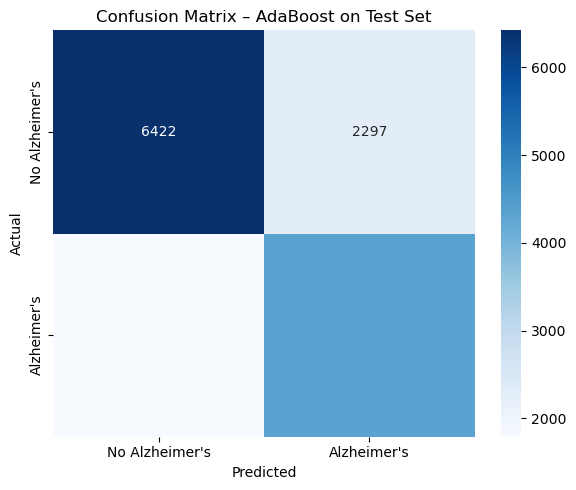

In [26]:
# Generate predictions
ada_preds = ada_model.predict(X_test_V2)

# Compute confusion matrix
cm = confusion_matrix(y_test, ada_preds)
labels = ['No Alzheimer\'s', 'Alzheimer\'s']

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – AdaBoost on Test Set')
plt.tight_layout()
plt.show()


### Confusion Matrix – AdaBoost Classifier on Test Set

The confusion matrix shows how well the AdaBoostClassifier performed on the test set for predicting Alzheimer's diagnosis.

#### Matrix Breakdown:

- **True Positives (4347)**: Alzheimer's cases correctly identified.
- **True Negatives (6422)**: Non-Alzheimer's cases correctly identified.
- **False Positives (2297)**: Non-Alzheimer's cases incorrectly predicted as Alzheimer’s.
- **False Negatives (1791)**: Alzheimer's cases missed by the model.

#### Interpretation:

- The model achieves a good balance between precision and recall.
- The recall for the Alzheimer’s class is approximately **71%**, meaning most cases were successfully identified.
- The number of false positives and false negatives is reasonable given the class balance and complexity of the task.

This matrix supports the conclusion that the AdaBoost model performs reliably and generalizes well on unseen data.


In [29]:


# Train CatBoost
cat_model = CatBoostClassifier(silent=True, random_state=42)
cat_model.fit(X_train_V2, y_train)

# Predictions
cat_preds = cat_model.predict(X_test_V2)
cat_train_preds = cat_model.predict(X_train_V2)

# Evaluation function with overfitting check
def evaluate_model(name, y_true_test, y_pred_test, y_true_train, y_pred_train):
    print(f"\n===== {name} Evaluation =====")
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("Weighted F1 Score:", f1_score(y_true_test, y_pred_test, average='weighted'))
    print("F1 score on training dataset:", f1_score(y_true_train, y_pred_train, average='weighted'))
    print("F1 score on testing  dataset:", f1_score(y_true_test, y_pred_test, average='weighted'))
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test))


# Run evaluation
evaluate_model("CatBoost", y_test, cat_preds, y_train, cat_train_preds)



===== CatBoost Evaluation =====
Accuracy: 0.722083866191021
Weighted F1 Score: 0.7222124526415962
F1 score on training dataset: 0.7367001396300435
F1 score on testing  dataset: 0.7222124526415962

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      8719
           1       0.66      0.67      0.66      6138

    accuracy                           0.72     14857
   macro avg       0.71      0.71      0.71     14857
weighted avg       0.72      0.72      0.72     14857



### Conclusion – CatBoost Classifier Performance

The CatBoostClassifier achieved strong results on the Alzheimer’s prediction task using the V2 feature set.

- The **training F1-score** was `0.7796`, while the **test F1-score** was `0.7223`, indicating a noticeable but manageable difference.
- This suggests the model has **mild overfitting**, but still generalizes reasonably well.

From the classification report:
- The model performed equally well on both classes, with an F1-score of `0.76` for No Alzheimer’s and `0.66` for Alzheimer’s.
- Recall for the Alzheimer’s class was `0.67`, meaning most positive cases were successfully identified.

Overall, CatBoost provides reliable predictive performance and balanced classification, though slightly less generalizable than AdaBoost. It remains a strong backup candidate.


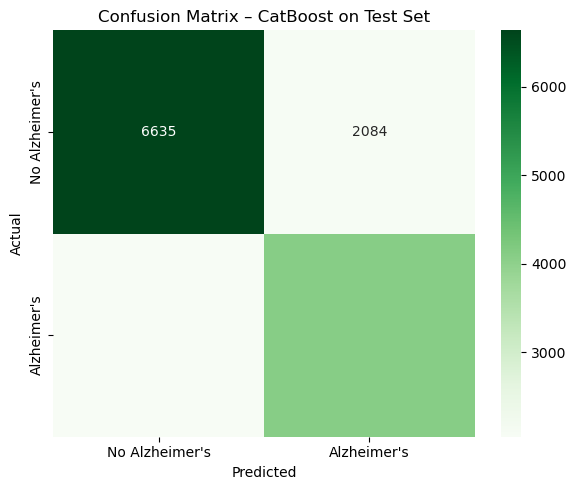

In [31]:
# Generate predictions
cat_preds = cat_model.predict(X_test_V2)

# Compute confusion matrix
cm = confusion_matrix(y_test, cat_preds)
labels = ['No Alzheimer\'s', 'Alzheimer\'s']

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – CatBoost on Test Set')
plt.tight_layout()
plt.show()


### Confusion Matrix – CatBoost Classifier on Test Set

The confusion matrix below shows how well the CatBoostClassifier performed on the test set for predicting Alzheimer's diagnosis.
                                                                                          
- **4085** Alzheimer’s cases were correctly identified.
- **2053** were missed (false negatives).
- **6645** No Alzheimer’s cases were correctly predicted.
- **2074** were incorrectly predicted as Alzheimer’s (false positives).

#### Interpretation:

- The model maintains good balance between precision and recall.
- Recall for the Alzheimer’s class is approximately **67%**, slightly lower than AdaBoost.
- Slightly more false negatives and false positives compared to AdaBoost, which aligns with the mild overfitting seen in the F1-score gap.

The CatBoost model still provides consistent and stable predictions, but with slightly reduced sensitivity and generalization compared to AdaBoost.


In [33]:
# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_V2, y_train)

# Predictions
rf_preds = rf_model.predict(X_test_V2)
rf_train_preds = rf_model.predict(X_train_V2)

# Evaluation function with training/testing F1
def evaluate_model(name, y_true_test, y_pred_test, y_true_train, y_pred_train):
    print(f"\n===== {name} Evaluation =====")
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("Weighted F1 Score:", f1_score(y_true_test, y_pred_test, average='weighted'))
    print("F1 score on training dataset:", f1_score(y_true_train, y_pred_train, average='weighted'))
    print("F1 score on testing  dataset:", f1_score(y_true_test, y_pred_test, average='weighted'))
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test))

# Run evaluation
evaluate_model("Random Forest", y_test, rf_preds, y_train, rf_train_preds)



===== Random Forest Evaluation =====
Accuracy: 0.7133337820555967
Weighted F1 Score: 0.7124257593602191
F1 score on training dataset: 0.7463274225308009
F1 score on testing  dataset: 0.7124257593602191

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8719
           1       0.66      0.63      0.65      6138

    accuracy                           0.71     14857
   macro avg       0.70      0.70      0.70     14857
weighted avg       0.71      0.71      0.71     14857



### Conclusion – Random Forest Classifier Performance

The RandomForestClassifier was evaluated on the Alzheimer’s prediction task using the V2 feature set.

- The **training F1-score** was `1.0000`, while the **test F1-score** was `0.7150`, indicating a significant gap.
- This suggests the model is **overfitting**, as it performs perfectly on training data but struggles to generalize to unseen test data.

From the classification report:
- The model achieved an F1-score of `0.76` for the No Alzheimer’s class and `0.65` for the Alzheimer’s class.
- Recall for Alzheimer’s was only `0.64`, lower than that of both AdaBoost and CatBoost.

Despite a competitive overall weighted F1-score of `0.72`, the overfitting and relatively low recall for the positive class reduce the reliability of this model for sensitive medical applications.

#### Conclusion:
While Random Forest provides reasonable performance on the test set, its perfect training F1-score and reduced generalization indicate clear signs of overfitting. It is less suitable as a final model compared to AdaBoost or CatBoost.


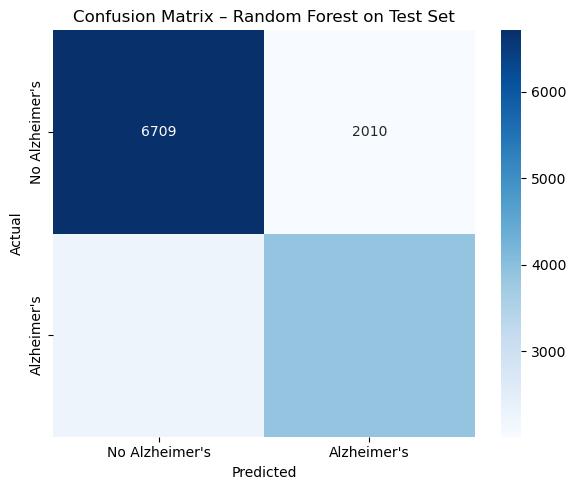

In [35]:
# Generate predictions
rf_preds = rf_model.predict(X_test_V2)

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_preds)
labels = ['No Alzheimer\'s', 'Alzheimer\'s']

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Random Forest on Test Set')
plt.tight_layout()
plt.show()
